In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os.path as osp
import xarray as xr
import sys
import os
import glob
import pickle5 as pickle
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import cascaded_union
import imageio

import utils

### Load shape data

In [2]:
d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
departure_area = gpd.read_file(osp.join(d, 'departure_area.shp'))
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')

### Individual-Based Model Results

In [3]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-19 15:13:36.750872'
traj, states, time = utils.load_sim_results(abm_path)
T = len(time)

In [15]:
print(traj.shape, states.shape, time.shape)

(1465, 50000, 2) (1465, 50000) (1465,)


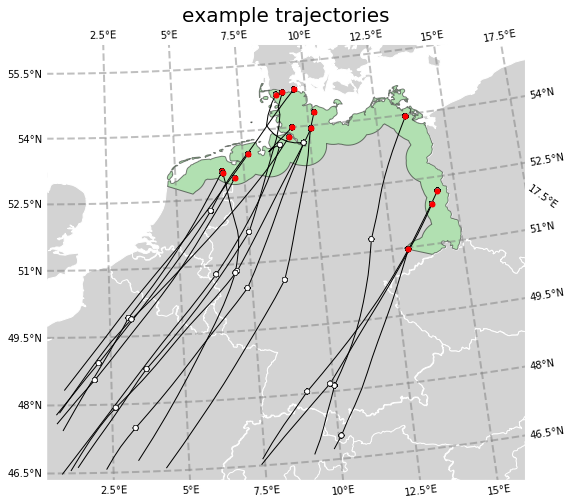

In [13]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
utils.plot_trajectories(ax, countries, departure_area, traj, states, birds=range(10,25))
ax.set_title('example trajectories', fontsize=20);

In [14]:
# radar area counts [air]
radars = [Point(row.x, row.y).buffer(25_000) for i, row in voronoi.iterrows()]
radars = gpd.GeoDataFrame({'radar': voronoi['radar'], 'geometry': radars}, crs='epsg:3035').to_crs(epsg='4326')
counts_rad, names_rad = utils.aggregate(traj, states, radars, range(T), state=1)
counts_rad = counts_rad.fillna(0)
rad_areas = radars.to_crs(epsg='3035').area

In [ ]:
# voronoi cell counts [air]
counts_vor, names_vor = utils.aggregate(traj, states, voronoi, range(T), state=1)
counts_vor = counts_vor.fillna(0)
vor_areas = voronoi.to_crs(epsg='3035').area

In [ ]:
# voronoi cell counts [ground]
counts_vor_gr, _ = utils.aggregate(traj, states, voronoi, range(T), state=0)
counts_vor_gr = counts_vor_gr.fillna(0)

#### Total Bird Counts per Hour

In [ ]:
stop = -1
t_range = np.arange(T)[:stop]
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(t_range, [counts_vor[f'n_birds_{t}'].sum() for t in t_range])
ax.set(ylabel='total count')
plt.xticks(t_range[::48], time[:stop:48], rotation=45, ha='right');
fig.tight_layout()

#### Bird Counts per Voronoi Cell per Hour

In [ ]:
extent = [0.36, 46.36, 16.07, 55.40]
n_start = [128, 152]

fig, axes = plt.subplots(len(n_start), len(t_range), figsize=(len(t_range)*4, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
for i, start in enumerate(n_start):
    t_range = [start + dt*2 for dt in range(6)]
    for j, tidx in enumerate(t_range):
        axes[i,j].set_title(time[tidx])
        axes[i,j] = gplt.polyplot(countries, ax=axes[i,j], edgecolor="black", extent=extent, zorder=1)
        gplt.choropleth(counts_vor, hue=names_vor[tidx], edgecolor='white', linewidth=1, ax=axes[i,j], alpha=0.5, zorder=0,
            cmap='Greens', legend=False, extent=extent);